# Spectral diversity metrics


Adapted from:

Féret, J. B., & de Boissieu, F. (2020).
biodivMapR: An r package for α‐and β‐diversity mapping
using remotely sensed images.
Methods in Ecology and Evolution, 11(1), 64-70.
https://doi.org/10.1111/2041-210X.13310
        

In [1]:
import numpy as np
import hytools_lite as htl
from hytools_lite.io.envi import WriteENVI
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from skimage.util import view_as_blocks
from numba import jit
import matplotlib.pyplot as plt

### Load reflectance image

In [16]:
# Yellowstone National Park PRISMA image
rfl_file = '/data2/prisma/rfl/PRS_20210621181605_20210621181609_0001_srtm/output/PRS_20210621181605_20210621181609_0001_rfl_prj_rfl'
rfl = htl.HyTools()
rfl.read_file(rfl_file,'envi')
rfl.create_bad_bands([[300,400],[1300,1450],[1780,2000],[2450,2600]])

### Set a mask for pixel selection

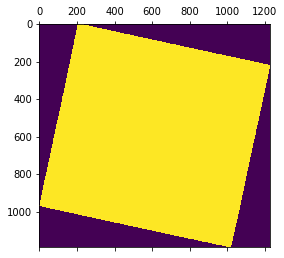

In [17]:
ndvi_threshold = -1
ndvi = rfl.ndi()

# Set a mask from which to sample for PCA
rfl.mask['sample'] = (rfl.mask['no_data']) & (ndvi > ndvi_threshold)

plt.matshow(rfl.mask['sample'])

### Subsample a set of pixels for PCA

In [18]:
# Percent of unmasked pixels to sample
sample_size = .2

sub_samples = np.zeros((rfl.lines,rfl.columns)).astype(bool)
idx = np.array(np.where(rfl.mask['sample'])).T
idxRand= idx[np.random.choice(range(len(idx)),int(len(idx)*sample_size), replace = False)].T
sub_samples[idxRand[0],idxRand[1]] = True
rfl.mask['samples'] = sub_samples

X = []

for band_num,band in enumerate(rfl.bad_bands):
    if ~band:
        X.append(rfl.get_band(band_num,mask='samples'))

X = np.array(X).T

### Run PCA and select number of components for K-means clustering

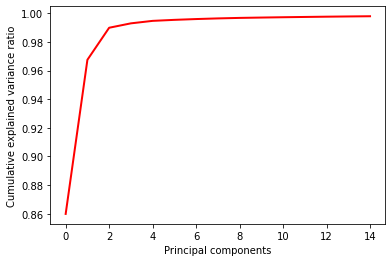

In [19]:
# Center, scale and fit PCA transform
x_mean = X.mean(axis=0)[np.newaxis,:]
X -=x_mean
x_std = X.std(axis=0,ddof=1)[np.newaxis,:]
X /=x_std
X = X[~np.isnan(X.sum(axis=1)) & ~np.isinf(X.sum(axis=1)),:]

#Perform initial PCA fit
pca = PCA(n_components=15)
pca.fit(X)

fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)
ax.plot(np.cumsum(pca.explained_variance_ratio_), c= 'r',lw=2)
ax.set_xlabel("Principal components")
_ = ax.set_ylabel("Cumulative explained variance ratio")

In [20]:
comps = int(input("Number of components to use: "))

Number of components to use: 6


### Rerun PCA with user selection components

In [22]:
pca = PCA(n_components=comps)
pca.fit(X)

PCA(n_components=6)

### Apply PCA transform to entire image

In [23]:
pca_transform = np.zeros((rfl.lines,rfl.columns,comps))
iterator = rfl.iterate(by = 'chunk',chunk_size = (500,500))

while not iterator.complete:
    chunk = iterator.read_next()
    X_chunk = chunk[:,:,~rfl.bad_bands].astype(np.float32)
    X_chunk = X_chunk.reshape((X_chunk.shape[0]*X_chunk.shape[1],X_chunk.shape[2]))
    X_chunk -=x_mean
    X_chunk /=x_std
    X_chunk[np.isnan(X_chunk) | np.isinf(X_chunk)] = 0
    pca_chunk=  pca.transform(X_chunk)
    pca_chunk = pca_chunk.reshape((chunk.shape[0],chunk.shape[1],comps))
    pca_chunk[chunk[:,:,0] == rfl.no_data] =0
    pca_transform[iterator.current_line:iterator.current_line+pca_chunk.shape[0],
                  iterator.current_column:iterator.current_column+pca_chunk.shape[1]] = pca_chunk


### Plot PCA bands

(-0.5, 1229.5, 1188.5, -0.5)

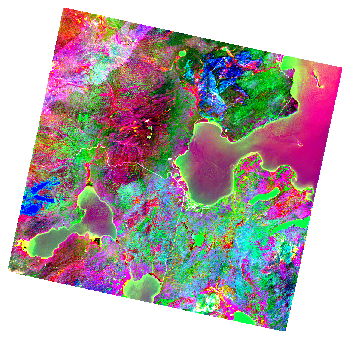

In [34]:
red = pca_transform[:,:,2]
green = pca_transform[:,:,3]
blue = pca_transform[:,:,4]
prgb=  np.stack([red,green,blue])
prgb = np.moveaxis(prgb,0,-1).astype(float)
prgb[prgb ==rfl.no_data] = np.nan
bottom = np.nanpercentile(prgb,5,axis = (0,1))
top = np.nanpercentile(prgb,95,axis = (0,1))
prgb = np.clip(prgb,bottom,top)
prgb = (prgb-np.nanmin(prgb,axis=(0,1)))/(np.nanmax(prgb,axis= (0,1))-np.nanmin(prgb,axis= (0,1)))
prgb[~rfl.mask['no_data']] = 1

fig = plt.figure(figsize = (6,6),facecolor='w')
fig.tight_layout()
ax = fig.add_subplot(111)
ax.matshow(prgb)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

### Perform unsupervised classification using K-means clustering

In [43]:
nclusters = int(input("Number of clusters: "))

Number of clusters: 25


(-0.5, 1229.5, 1188.5, -0.5)

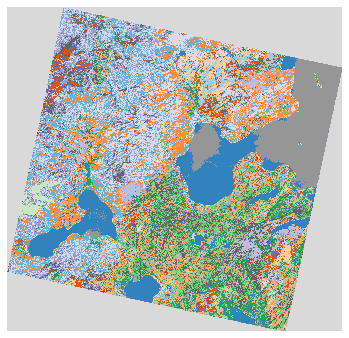

In [44]:
pca_sample= pca.transform(X.astype(float))
clusters = KMeans(n_clusters=nclusters)
clusters.fit(pca_sample)
classes = clusters.predict(pca_transform.reshape(rfl.lines*rfl.columns,comps)).reshape(rfl.lines,rfl.columns)
classes[~rfl.mask['no_data']] = nclusters

fig = plt.figure(figsize = (6,6),facecolor='w')
fig.tight_layout()
ax = fig.add_subplot(111)
ax.matshow(classes,cmap = plt.get_cmap('tab20c'))
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

### Calculate Shannon and Simpson diversity indices

In [45]:
@jit(nopython=True)
def calc_alpha(classes,window,nclusters):
    shannon = np.zeros(classes.shape)
    simpson = np.zeros(classes.shape)
    windows_pixels = window**2

    lines = classes.shape[0]
    columns = classes.shape[0]

    half_window = int(window/2)

    for line in range(half_window,lines-half_window):
        for col in range(half_window,columns-half_window):
            nbhd = classes[line-half_window:line+half_window,col-half_window:col+half_window].flatten()
            cover = [0 for x in range(nclusters)]
            nbhd_size = 0

            for a in nbhd:
                if a !=nclusters:
                    cover[a]+=1
                    nbhd_size+=1

            if nbhd_size/windows_pixels < .75:
                continue

            shn,smp = 0,0

            for c in range(nclusters):
                if cover[c] !=0:
                    p = cover[c]/nbhd_size
                    shn += p * np.log(p)
                    smp += p**2
            shannon[line,col] = -shn
            simpson[line,col] = 1/smp
    return shannon,simpson

In [49]:
window = int(input("Enter sliding window size in pixels for calculating diveristy indices: "))

Enter window size in pixels for calculating diveristy indices: 20


### Run algorithms and plot results

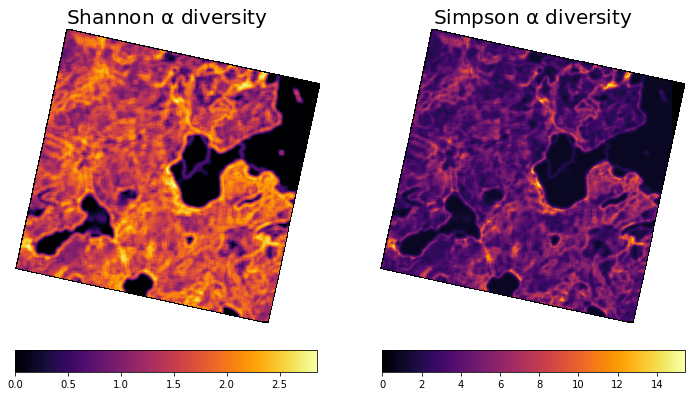

In [59]:
shannon,simpson = calc_alpha(classes,window,nclusters)
shannon[~rfl.mask['no_data']] = np.nan
simpson[~rfl.mask['no_data']] = np.nan

fig = plt.figure(figsize = (12,6),facecolor='w')
fig.tight_layout()

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

cax1 = fig.add_axes((0.125,.05,.35,.05))
cax2 = fig.add_axes((0.55,.05,.35,.05))

sc1 = ax1.matshow(shannon,cmap = plt.get_cmap('inferno'))
sc2 = ax2.matshow(simpson,cmap = plt.get_cmap('inferno'))

cbar1 = fig.colorbar(sc1, cax=cax1,
                    orientation='horizontal')
cbar1.set_label(label = '', size='x-large')

cbar2 = fig.colorbar(sc2, cax=cax2,
                    orientation='horizontal')
cbar2.set_label(label = '', size='x-large')

for ax in [ax1,ax2]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

ax1.set_title(r"$\mathrm{Shannon\ \alpha\ diversity}$",fontsize= 20)
_ = ax2.set_title(r"$\mathrm{Simpson\ \alpha\ diversity}$",fontsize= 20)

### Calculate beta diversity

In [61]:
window = int(input("Enter block size in pixels for calculating diveristy indices: "))

Enter block size in pixels for calculating diveristy indices: 20


### Classification map into window x window sized blocks

In [63]:
column_end =window*(rfl.columns//window)
line_end = window*(rfl.lines//window)

image_blocks = view_as_blocks(classes[:line_end,:column_end],(window,window))
image_blocks = image_blocks.reshape(image_blocks.shape[0]*image_blocks.shape[1],
                                    window,window)

In [60]:
@jit(nopython=True)
def calc_bray_curtis_blocks(image_blocks,nclusters):

    windows_pixels = image_blocks.shape[1]*image_blocks.shape[2]
    bray_curtis = np.full((image_blocks.shape[0],image_blocks.shape[0]),-4.0)

    i=0
    for nbhd1 in image_blocks:
        nbhd1 = nbhd1.flatten()
        cover1 = [0 for x in range(nclusters)]
        nbhd1_size = 0

        for a in nbhd1:
            if a !=nclusters:
                cover1[a]+=1
                nbhd1_size+=1
        if nbhd1_size/windows_pixels < .75:
            i+=1
            continue
        j=i
        for nbhd2 in image_blocks[i:]:
            nbhd2 = nbhd2.flatten()
            cover2 = [0 for x in range(nclusters)]
            nbhd2_size = 0

            for a in nbhd2:
                if a !=nclusters:
                    cover2[a]+=1
                    nbhd2_size+=1

            if nbhd2_size/windows_pixels < .75:
                j+=1
                continue

            numerator = 0
            for c in range(nclusters):
                numerator += np.abs(cover1[c]-cover2[c])

            bray_curtis[i,j] = numerator/(nbhd1_size+nbhd2_size)
            bray_curtis[j,i] = bray_curtis[i,j]
            j+=1
        i+=1
    return bray_curtis

### Calculater Bray-Curtis dissimilarity matrix

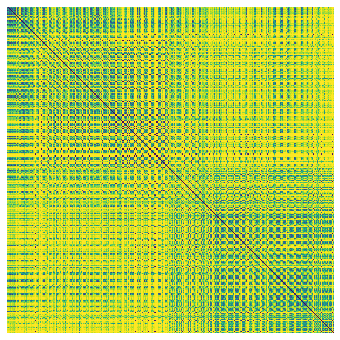

In [69]:
bray_curtis = calc_bray_curtis_blocks(image_blocks,nclusters)

#Filter dissimilarity matrix
bc_filt = bray_curtis[:,bray_curtis.sum(axis=0) != bray_curtis.shape[1]*-4]
bc_filt = bc_filt[bc_filt.sum(axis=1) != bc_filt.shape[1]*-4,:]

fig = plt.figure(figsize = (6,6),facecolor='w')
fig.tight_layout()
ax = fig.add_subplot(111)
ax.matshow(bc_filt)
ax.set_xticks([])
ax.set_yticks([])
_ = ax.axis('off')

### Perform multidimensional scaling

In [73]:
nmds = MDS(n_components=3,n_jobs= 8)
nmds.dissimilarity = 'precomputed'
coords = nmds.fit_transform(bc_filt)

full_coords = np.zeros((bray_curtis.shape[0],3))
full_coords[bray_curtis.sum(axis=0) != bray_curtis.shape[0]*-4] = coords

image_blocks = view_as_blocks(classes[:line_end,:column_end],(window,window))
beta = full_coords.reshape((image_blocks.shape[0],image_blocks.shape[1],3))
beta[image_blocks.mean(axis = (2,3))<0] = np.nan

### Plot beta map

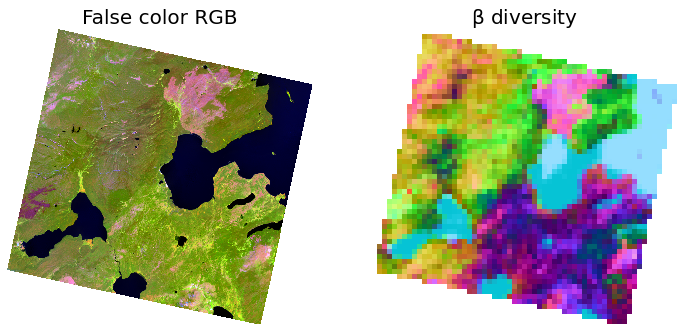

In [93]:
# Scale beta map from 0-1
bottom = np.nanpercentile(np.nanmin(beta)+beta,1,axis = (0,1))
top = np.nanpercentile(np.nanmin(beta)+beta,99,axis = (0,1))
pbc = np.clip(np.nanmin(beta)+beta,bottom,top)
pbc = (pbc-np.nanmin(pbc,axis=(0,1)))/(np.nanmax(pbc,axis= (0,1))-np.nanmin(pbc,axis= (0,1)))
pbc[pbc == pbc[0,0]] = 1

# Scale rgb image from 0-1
red = rfl.get_wave(1660)
green = rfl.get_wave(850)
blue = rfl.get_wave(440)
rgb=  np.stack([red,green,blue])
rgb = np.moveaxis(rgb,0,-1).astype(float)
rgb[rgb ==rfl.no_data] = np.nan

bottom = np.nanpercentile(rgb,5,axis = (0,1))
top = np.nanpercentile(rgb,99.9,axis = (0,1))
rgb = np.clip(rgb,bottom,top)
rgb = (rgb-np.nanmin(rgb,axis=(0,1)))/(np.nanmax(rgb,axis= (0,1))-np.nanmin(rgb,axis= (0,1)))
rgb[~rfl.mask['no_data']] = 1

fig = plt.figure(figsize = (12,6),facecolor='w')
fig.tight_layout()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.matshow(rgb)
ax2.matshow(pbc)

ax1.set_title('False color RGB',fontsize= 20)
ax2.set_title(r"$\mathrm{\beta\ diversity}$",fontsize= 20)

for ax in [ax1,ax2]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
